In [14]:
import os
os.environ['OMP_NUM_THREADS'] = '4' # set number of OpenMP threads to run in parallel

from qoc import grape_schroedinger_discrete
from qoc.standard import TargetStateInfidelity

import autograd.numpy as anp
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix

import time

%matplotlib inline

In [15]:
def scipy_expv(N, l):
    """
    This function contains a simple example of grape
    on the schroedinger equation using time discrete
    control parameters to evolve a cavity from the
    Fock state 0 to the Fock state 1. Even though the
    system is not physical, it can be used to measure
    memory

    Args:
    N :: int - Numbers of time steps
    l :: int - Hilbert space dimension
    """

    HILBERT_SIZE = l
    diagnol = np.arange(HILBERT_SIZE)
    up_diagnol = np.sqrt(diagnol)
    low_diagnol = np.sqrt(np.arange(1, HILBERT_SIZE + 1))
    data = [low_diagnol, diagnol, up_diagnol]
    offsets = [-1, 0, 1]
    H_SYSTEM_0 = dia_matrix((data, offsets), shape=(HILBERT_SIZE, HILBERT_SIZE))
    sigmax = dia_matrix(([low_diagnol, up_diagnol], [-1, 1]),
                        shape=(HILBERT_SIZE, HILBERT_SIZE))

    # Only real control amplitudes are supported!
    hamiltonian = lambda controls, time: (H_SYSTEM_0
                                          + controls[0] * sigmax)

    # Define the problem.
    CAVITY_VACUUM = anp.zeros((l, 1))
    CAVITY_ZERO = anp.copy(CAVITY_VACUUM)
    CAVITY_ZERO[0, 0] = 1
    CAVITY_ONE = anp.copy(CAVITY_VACUUM)
    CAVITY_ONE[1, 0] = 1
    CAVITY_VACUUM = anp.zeros((l, 1))

    INITIAL_STATE_0 = anp.copy(CAVITY_VACUUM)
    INITIAL_STATE_0[0,0] = 1
    TARGET_STATE_0 = anp.copy(CAVITY_VACUUM)
    TARGET_STATE_0[1,0] = 1
    INITIAL_STATES = anp.stack((INITIAL_STATE_0,), axis=0)
    TARGET_STATES = anp.stack((TARGET_STATE_0,), axis=0)
    COSTS = [TargetStateInfidelity(TARGET_STATES)]

    # Define the optimization.
    COMPLEX_CONTROLS = False
    CONTROL_COUNT = 1
    EVOLUTION_TIME = 1e-6  # nanoseconds
    CONTROL_EVAL_COUNT = SYSTEM_EVAL_COUNT = N + 1
    ITERATION_COUNT = 5

    # Define output.
    LOG_ITERATION_STEP = 1
    CONTROL_HAMILTONIAN = [sigmax]

    MANUAL_PARAMETER = {"control_hamiltonian": CONTROL_HAMILTONIAN,
                        "manual_gradient_mode": True, "tol": 1e-6}

    result = grape_schroedinger_discrete(CONTROL_COUNT, CONTROL_EVAL_COUNT,
                                         COSTS, EVOLUTION_TIME, hamiltonian,
                                         INITIAL_STATES, SYSTEM_EVAL_COUNT,
                                         complex_controls=COMPLEX_CONTROLS,
                                         iteration_count=ITERATION_COUNT,
                                         log_iteration_step=LOG_ITERATION_STEP,
                                         manual_parameter=MANUAL_PARAMETER)

In [16]:
def AD(N, l):
    """
    This function contains a simple example of grape
    on the schroedinger equation using time discrete
    control parameters to evolve a cavity from the
    Fock state 0 to the Fock state 1. Even though the
    system is not physical, it can be used to measure
    memory

    Args:
    N :: int - Numbers of time steps
    l :: int - Hilbert space dimension
    """

    HILBERT_SIZE = l
    diagnol = np.arange(HILBERT_SIZE)
    up_diagnol = np.sqrt(diagnol)
    low_diagnol = np.sqrt(np.arange(1, HILBERT_SIZE + 1))
    data = [low_diagnol, diagnol, up_diagnol]
    offsets = [-1, 0, 1]
    H_SYSTEM_0 = dia_matrix((data, offsets), shape=(HILBERT_SIZE, HILBERT_SIZE))
    sigmax = dia_matrix(([low_diagnol, up_diagnol], [-1, 1]),
                        shape=(HILBERT_SIZE, HILBERT_SIZE))

    H_SYSTEM_0 = anp.array(H_SYSTEM_0.toarray())
    sigmax = anp.array(sigmax.toarray())

    # Only real control amplitudes are supported!
    hamiltonian = lambda controls, time: (H_SYSTEM_0
                                          + controls[0] * sigmax)

    # Define the problem.
    CAVITY_VACUUM = anp.zeros((l, 1))
    CAVITY_ZERO = anp.copy(CAVITY_VACUUM)
    CAVITY_ZERO[0, 0] = 1
    CAVITY_ONE = anp.copy(CAVITY_VACUUM)
    CAVITY_ONE[1, 0] = 1
    CAVITY_VACUUM = anp.zeros((l, 1))

    INITIAL_STATE_0 = anp.copy(CAVITY_VACUUM)
    INITIAL_STATE_0[0,0] = 1
    TARGET_STATE_0 = anp.copy(CAVITY_VACUUM)
    TARGET_STATE_0[1,0] = 1
    INITIAL_STATES = anp.stack((INITIAL_STATE_0,), axis=0)
    TARGET_STATES = anp.stack((TARGET_STATE_0,), axis=0)
    COSTS = [TargetStateInfidelity(TARGET_STATES)]

    # Define the optimization.
    COMPLEX_CONTROLS = False
    CONTROL_COUNT = 1
    EVOLUTION_TIME = 1e-6  # nanoseconds
    CONTROL_EVAL_COUNT = SYSTEM_EVAL_COUNT = N + 1
    ITERATION_COUNT = 5

    # Define output.
    LOG_ITERATION_STEP = 1
    CONTROL_HAMILTONIAN = [sigmax]

    result = grape_schroedinger_discrete(CONTROL_COUNT, CONTROL_EVAL_COUNT,
                                         COSTS, EVOLUTION_TIME, hamiltonian,
                                         INITIAL_STATES, SYSTEM_EVAL_COUNT,
                                         complex_controls=COMPLEX_CONTROLS,
                                         iteration_count=ITERATION_COUNT,
                                         log_iteration_step=LOG_ITERATION_STEP,)

In [21]:
# naive Krylov output
h_dims = range(10, 1000, 100)
ktimes_scipy_openmp = []
for dim in h_dims:
    kstart = time.time()
    scipy_expv(1, dim)
    kend = time.time()

    ktime = kend-kstart
    ktimes_scipy_openmp.append(ktime)

iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 9.33380951e-13
  1    | 1.00000000e+00 | 9.33380985e-13
  2    | 1.00000000e+00 | 9.33381018e-13
  3    | 1.00000000e+00 | 9.33381052e-13
  4    | 1.00000000e+00 | 9.33381086e-13
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 9.33380951e-13
  1    | 1.00000000e+00 | 9.33380985e-13
  2    | 1.00000000e+00 | 9.33381018e-13
  3    | 1.00000000e+00 | 9.33381052e-13
  4    | 1.00000000e+00 | 9.33381086e-13
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 9.33380951e-13
  1    | 1.00000000e+00 | 9.33380985e-13
  2    | 1.00000000e+00 | 9.33381018e-13
  3    | 1.00000000e+00 | 9.33381052e-13
  4    | 1.00000000e+00 | 9.33381086e-13
iter   |   total error  |    grads_l2   
  0    | 1.00000000e+00 | 9.33380951e-13
  1    | 1.00000000e+00 | 9.33380985e-13
  2    | 1.00000000e+00 | 9.33381018e-13
  3    | 1.00000000e+00 | 9.33381052e-13
  4    | 1.00000000e+00 | 9.33381086e-13
iter   |   total

In [22]:
print(ktimes_scipy_openmp)

[0.14650487899780273, 0.10528993606567383, 0.08376288414001465, 0.09126496315002441, 0.09019327163696289, 0.08912491798400879, 0.10834002494812012, 0.09806203842163086, 0.1429307460784912, 0.15024375915527344]


In [1]:
# # AD output
# adtimes = []
# for dim in h_dims:
#     adstart = time.time()
#     AD(5, dim)
#     adend = time.time()
#
#     adtime = adend-adstart
#     adtimes.append(adtime)

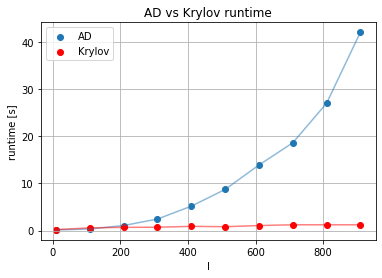

In [34]:
plt.scatter(h_dims, adtimes, color='C0', label="AD")
plt.plot(h_dims, adtimes, color='C0', alpha = 0.5)

plt.scatter(h_dims, ktimes, color='r', label="Krylov")
plt.plot(h_dims, ktimes, color='r', alpha = 0.5)

plt.xlabel("l")
plt.ylabel("runtime [s]")

plt.title("AD vs Krylov runtime")
plt.grid()
plt.legend()

plt.show()

In [23]:
times_ad = [0.12549805641174316, 0.3137378692626953, 1.0548009872436523, 2.440361976623535, 5.16273307800293, 8.718554973602295, 13.897977113723755, 18.615697145462036, 27.014513731002808, 42.077934980392456]
times_krylov_magnus = [0.1898491382598877, 0.5633950233459473, 0.6736938953399658, 0.6977560520172119, 0.8792262077331543, 0.8070337772369385, 1.0527050495147705, 1.2177798748016357, 1.209434986114502, 1.2146077156066895]
times_krylov_pyexpokit = [0.2308180332183838, 0.5363681316375732, 0.6581361293792725, 0.6247711181640625, 0.6761720180511475, 0.7147650718688965, 0.7632489204406738, 0.8393259048461914, 0.8628678321838379, 0.9217147827148438]
times_scipy = [0.13176989555358887, 0.13581418991088867, 0.12553811073303223, 0.1103360652923584, 0.11827301979064941, 0.1321089267730713, 0.12587904930114746, 0.16336393356323242, 0.16615009307861328, 0.12619781494140625]
times_scipy_openmp = [0.1359100341796875, 0.12116003036499023, 0.12153196334838867, 0.09893989562988281, 0.18100190162658691, 0.1517798900604248, 0.10602116584777832, 0.17594194412231445, 0.10915899276733398, 0.1106879711151123]
times_scipy_openmp1 = [0.17931103706359863, 0.11263799667358398, 0.11458182334899902, 0.10267806053161621, 0.11082196235656738, 0.10682487487792969, 0.1479649543762207, 0.1346580982208252, 0.13637018203735352, 0.09749460220336914]
times_scipy_openmp2 = [0.1275339126586914, 0.1078331470489502, 0.10687470436096191, 0.12043285369873047, 0.09015417098999023, 0.11866021156311035, 0.14934015274047852, 0.1068410873413086, 0.1038210391998291, 0.11232781410217285]
times_scipy_openmp3 = [0.14650487899780273, 0.10528993606567383, 0.08376288414001465, 0.09126496315002441, 0.09019327163696289, 0.08912491798400879, 0.10834002494812012, 0.09806203842163086, 0.1429307460784912, 0.15024375915527344]


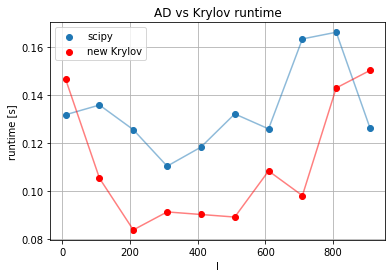

In [28]:
plt.scatter(h_dims, times_scipy, color='C0', label="scipy")
plt.plot(h_dims, times_scipy, color='C0', alpha = 0.5)

plt.scatter(h_dims, ktimes_scipy_openmp, color='r', label="new Krylov")
plt.plot(h_dims, ktimes_scipy_openmp, color='r', alpha = 0.5)

plt.xlabel("l")
plt.ylabel("runtime [s]")

plt.title("AD vs Krylov runtime")
plt.grid()
plt.legend()

plt.show()